# Machine Learning Calcimetry Regression

This document describes results that can be computed in this [notebook](../notebooks/regression.ipynb)

## Problem Statement

A collection of **3068** images of cores that looks like the following one is stored in a database. Each photo was preprocessed in order to define border of the core (blue and green line) and a red line is digitilized to delineate the center of the valid core. At some points a collection of calcimetry measures $\{m_i\}$ were acquired. As a first step, a thumbnail window (i.e an image $T$) is defined on the red line at each $i$ measure abscissa (blue and red rectangles).


![core](./regression_files/drill_bpe4023.png)

The question is the following **regression** question:
> Is it possible to find a predictor able to estimate the calcimetry value $m_i$ only looking at the thumbnail image

$$
m_i = f(T)
$$
where f is the regression function to be estimated.

## Our first dataset

With a thumbnail of size 128, we got **4067** valid measurement points that should be used. This defines the size of our dataset.
Each entry in the dataset is a tuple $(V_i, m_i)$


In [1]:
from calcimetry.mongo_api import MongoInfo
from calcimetry.thumbnail_api import ThumbnailAPI
from PIL import Image
import matplotlib.pyplot as plt
import io
import random
import base64

HOST = 'localhost'
PORT = 27010

# Load Dataset

random.seed(1)

mongo_info = MongoInfo(host=HOST, port=PORT)
thumb_list = []
with ThumbnailAPI(mongo_info=mongo_info) as thumb_api:
    size = thumb_api.size()
    print(size)
    for i in range(10):
        idx = int(random.random()*size)
        thumb = thumb_api.read(idx)
        thumb_list.append(thumb)
    #plt.imshow(thumb)

print('ok')
    

4067
ok



As illustration, we draw above a collection of 10 samples randomly selected among the 4067.
In addition to the picture of the thumbnail itself, an histogram of pixel values, the calcimetry measure at 1 minute and the id of the core are also given.
* To compute the histogram, each RGB thumbnail image was first converted to a gray level image.
* As each core photo differs in resolution, the thumbnail picture was resized when extracted so that the absolute size of the 128x128 pixels is the same for all thumbnails.

In [2]:
from IPython.display import Image, HTML, display


def get_histo(img):
    gray = img.convert('L')
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_axis_off()
    ax.plot(gray.histogram())
    img_byte_array = io.BytesIO()
    fig.savefig(img_byte_array, format='jpeg')
    plt.close(fig)
    return base64.b64encode(img_byte_array.getvalue()).decode()

def save_histo(img, filename):
    gray = img.convert('L')

    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_axis_off()
    ax.plot(gray.histogram())
    fig.savefig(filename, format='jpeg')
    plt.close(fig)


def to_base64(img: Image):
    byte_array = io.BytesIO()
    img.save(byte_array, format='jpeg')
    return base64.b64encode(byte_array.getvalue()).decode()


html_str = "<div style='display: inline-block; align:justify; border: 1px solid white;'>"
html_str +="<img style='width: 128px; margin: 0px; float: left; 'src='./regression_files/images_%d.jpg' />"
html_str += "<img style='width: 128px; margin: 0px; float: left; ' src='./regression_files/histo_%d.jpg' />"
html_str +="<P style='text-align: center;'>%s (%s)</P>"
html_str +="</div>\n"


all_str = " "
for i, t in enumerate(thumb_list):
    t.jpg.save(f"./regression_files/images_{i}.jpg", format="jpeg")
    save_histo(t.jpg, f"./regression_files/histo_{i}.jpg")
    all_str += html_str % (i, i, t.measurement.val_1m, t.measurement.image_id)
HTML(all_str)




## Features

To begin instead of predicting the calcimetry using directly the thumbnail pixel's matrix,  a "feature" approach was tried. 
On each thumbnail, some features are then computed (see this [notebook](../notebooks/image-quality-talk.ipynb) for more informations):
* `Focus` : The variance of the Laplacian can be a measure of the sharpness of the image, or the focus.
* `Gradient` : Magnitude of the gradient to get sharpness of edges, calculate maximum and standard deviation.
* `Colours` : The top five colours in the image from clustering analysis
* `BRISQUE` : blind/referenceless image spatial quality evaluator

As it was guess that somehow calcimetry was related with some grey level, some other features are also defined. 
* `mean_color` that is the mean of all `Colours` previously defined.
* `bin-1..5` that are 5 features build computing one 5 bins histogram on each thumbnail 

The following table summarizes all the features used in a first step once converted to pandas dataframe. To complete the dataset, the last column gives the expected calcimetry value expected to be deduced from this features.

In [3]:
import pandas as pd
import numpy as np
from calcimetry.thumbnail_api import ThumbnailAPI

n_bins = 6
def get_histo(t, n_bins):
    w, h = t.jpg.size
    histo, bins = np.histogram(t.jpg, bins=n_bins)
    return histo.astype(np.float64) / (w*h)

#create dataframe for learing
columns = [
    "focus", "mean_grad", "mean_color", "brisque"
]
for i in range(n_bins):
    columns.append(f"bin_{i}")
columns.append('target')
    
data = []

with ThumbnailAPI(mongo_info=mongo_info) as thumb_api:
    size = thumb_api.size()    
    for idx in range(size):
        #idx = int(random.random()*size)
        t = thumb_api.read(idx)
        row = [t.quality.focus, t.quality.gradient['ave'], np.mean(t.quality.colours), t.quality.brisque]
        histo = get_histo(t, n_bins)
        for i in range(n_bins):
            row.append(histo[i])
        row.append(float(t.measurement.val_1m))
        data.append(row)
    
df = pd.DataFrame(data, columns=columns)
print(f"there are {df.count()} samples")
df.head()

there are focus         4067
mean_grad     4067
mean_color    4067
brisque       4067
bin_0         4067
bin_1         4067
bin_2         4067
bin_3         4067
bin_4         4067
bin_5         4067
target        4067
dtype: int64 samples


,focus,mean_grad,mean_color,brisque,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,target
0,168.300274,42.614488,93.551401,25.967468,0.008850,0.133545,0.891785,1.164612,0.733643,0.067566,29.0
1,118.353516,32.405043,89.971384,20.834656,0.032227,0.120605,0.831970,1.268433,0.739990,0.006775,31.0
2,110.426135,32.370667,85.950415,26.956238,0.040649,0.094604,0.588196,0.704224,1.201477,0.370850,33.0
3,97.795724,29.870769,77.753587,28.365417,0.039551,0.114563,0.664185,0.872192,1.042480,0.267029,33.0
4,87.493495,28.363839,68.290218,23.031433,0.050659,0.149353,0.711792,0.901733,0.977112,0.209351,33.0


###  Normalization


As our features don't use the same range, a $z_i=(x_i-\mu_i)/\sigma_i$ normalization is performed to scale each feature in $[0,1]$ range 

In [4]:
normalized_df = df.copy()
for c in columns:
    if c == 'target':
        continue
    mean = normalized_df[c].mean()
    std = normalized_df[c].std()
    normalized_df[c] = (df[c] - mean) / std 

normalized_df.head()

,focus,mean_grad,mean_color,brisque,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,target
0,-0.048182,0.471487,-0.397528,-0.197146,-0.604047,-0.294992,0.929507,0.557339,-0.514068,-0.576702,29.0
1,-0.300642,-0.388002,-0.519708,-0.613800,-0.394549,-0.344614,0.797319,0.763671,-0.504145,-0.730560,31.0
2,-0.340712,-0.390896,-0.656938,-0.116883,-0.319064,-0.444328,0.258585,-0.357629,0.217261,0.190889,33.0
3,-0.404553,-0.601352,-0.936684,-0.002494,-0.328910,-0.367787,0.426518,-0.023810,-0.031286,-0.071875,33.0
4,-0.456627,-0.728214,-1.259654,-0.435478,-0.229357,-0.234368,0.531729,0.034899,-0.133472,-0.217854,33.0


## Exploring the dataset

Visual exploration of the dataset is always a good way to discover information contained in data
A correlation pairplot is then displayed to have a better look which characteristics are correlated with each others. 

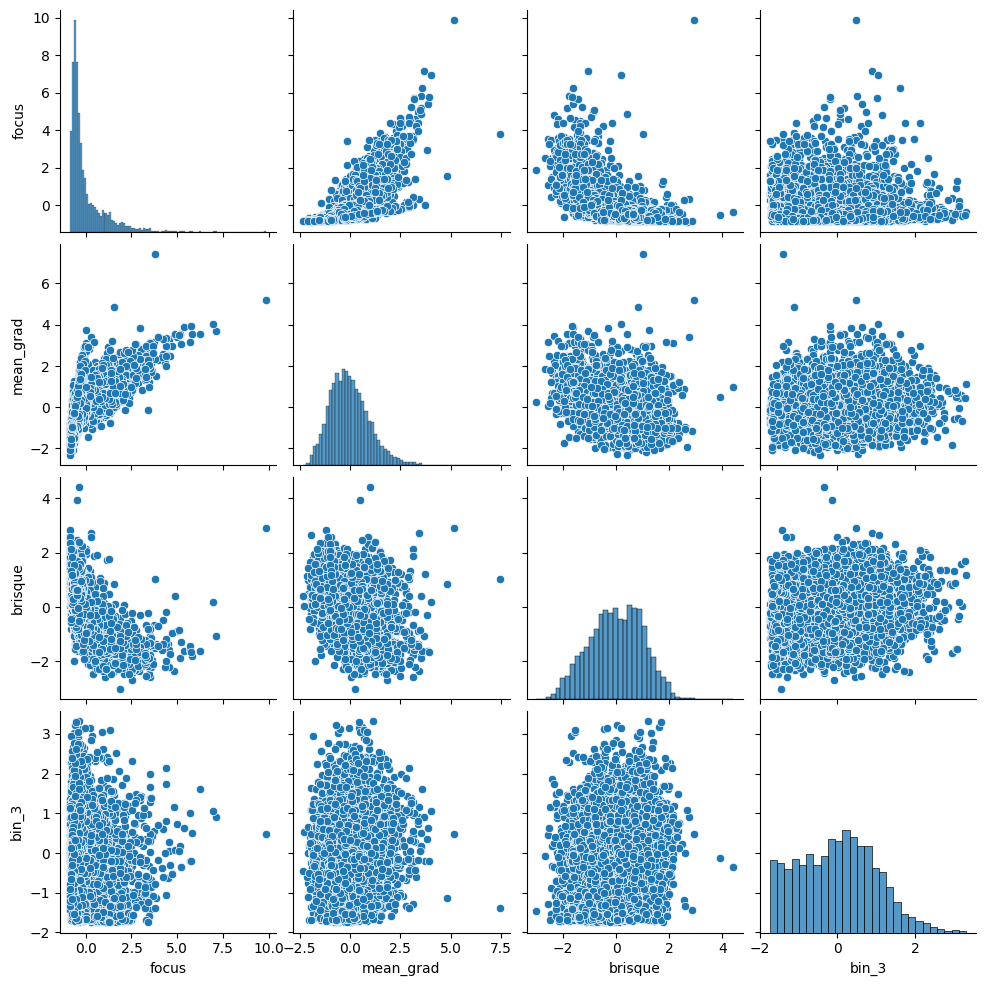

In [5]:
import seaborn as sns

# Here are selected some features to be plot.
selected_df = normalized_df[['focus', 'mean_grad', "brisque", "bin_3"]]
sns.pairplot(selected_df)

Then a correlation matrix can also be computed.

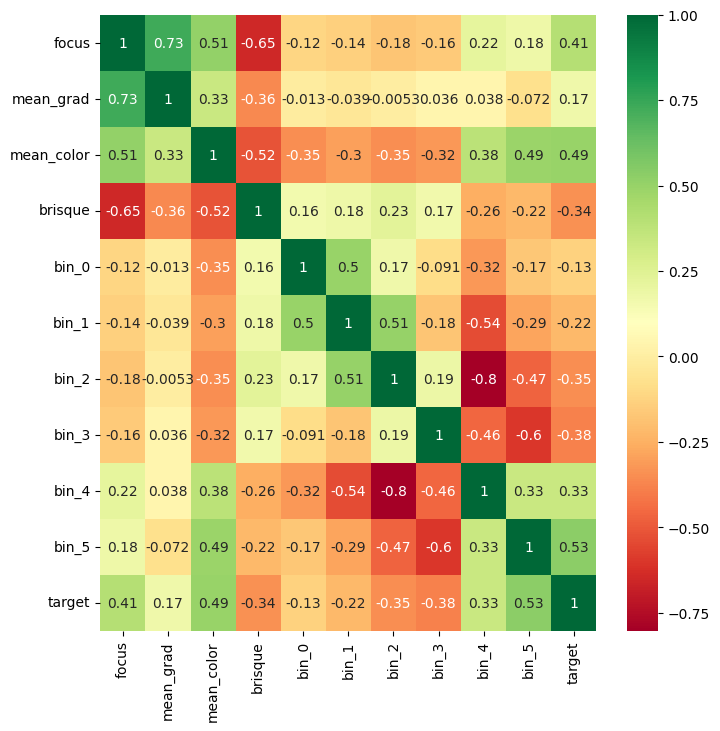

In [6]:
import seaborn as sns #visualization package
corr = normalized_df.corr()
plt.subplots(figsize=(8,8))
sns.heatmap(corr,cmap= 'RdYlGn',annot=True)
plt.show()

- As it can be seen on `pairplot` some features are highly correlated as `focus` with `mean_grad`
- In this matrix, it can be seen that the `target` (calcimetry) is poorly correlated with each feature if invidualy considered.

## Performing regression

### Training 

Remember performing regression is equivalent to find $f$ (learning parameters) so that $y=f(x)$ where $y$ is our calcimetry and $x$ is a vector built using all normalized features.

In [7]:

#independent variables / explanatory variables / features
x = normalized_df.drop(labels='target', axis=1)  #axis=1 means we drop data by column.
#x = normalized_df[['mean_color']]

#dependent variable / response / target variable / calcimetry
y = normalized_df['target']

Our dataset need to be split in two :
1. A **training** dataset that will be used to estimated paramaters of our models (~80% of the dataset)
1. A **testing** dataset that will be kept to test who good is our model to predict calcimetry2) On scinde en dataset d'apprentissage et de validation

In [8]:
from sklearn.model_selection import train_test_split
#splitting the dataset into 80%-20% train-test split 
train_x, test_x, train_y, test_y = train_test_split(x,y,test_size=0.10,random_state=123, shuffle=True)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(3660, 10)
(407, 10)
(3660,)
(407,)


Then regression is performed. Different models are available in the following cell from simple (`linear`) to more complicated (`extra_tree`). In this [notebook](./ExtraTreesRegressor.ipynb), python module `lazypredict` was used to benchmark many ML models.

In [9]:
from sklearn.utils import shuffle
import numpy as np

#independent variables / explanatory variables
x = df.drop(labels='target', axis=1)  #axis=1 means we drop data by column.
y = df['target']

X, y = shuffle(x,y, random_state=123)
X = X.astype(np.float32)

offset = int(X.shape[0] * 0.9)


X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

In [10]:
# from lazypredict.Supervised import LazyRegressor

# reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)

# models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# print(models)

The Gradient Boosting Regressor model is a machine learning approach that combines a number of weak regression models, in this instance decision trees, in an effort to produce predictions. The model's evaluation metrics can shed light on how well it is performing.

The target variable's variability is explained by the model to the tune of 61%, according to the R-squared value of 0.61. This indicates that 61% of the total variation in the observed data can be accounted for by the model's predictions.

The adjusted R-squared value, which is 0.60 and somewhat less than the R-squared value, accounts for the number of predictors employed in the model. As a result, it may be that some of the predictors are neither pertinent or useful for the target variable.

The average difference between the actual and anticipated values is measured by the root mean squared error (RMSE), which has a value of 12.78. It shows that there is an average inaccuracy of 12.78 units in the target variable for the model's predictions.

In [11]:
from calcimetry.mongo_api import MongoInfo
from calcimetry.thumbnail_api import ThumbnailAPI
from PIL import Image
import matplotlib.pyplot as plt
import io
import random
import base64

HOST = 'localhost'
PORT = 27010

# Load Dataset

def get_histo(img):
    gray = img.convert('L')

    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_axis_off()
    ax.plot(gray.histogram())
    img_byte_array = io.BytesIO()
    fig.savefig(img_byte_array, format='jpeg')
    plt.close(fig)
    return base64.b64encode(img_byte_array.getvalue()).decode()


random.seed(1)

mongo_info = MongoInfo(host=HOST, port=PORT)
thumb_list = []
with ThumbnailAPI(mongo_info=mongo_info) as thumb_api:
    size = thumb_api.size()
    print(size)
    for i in range(50):
        idx = int(random.random()*size)
        thumb = thumb_api.read(idx)
        thumb_list.append(thumb)
    #plt.imshow(thumb)
    

4067


In [12]:
from sklearn.linear_model import BayesianRidge, LinearRegression, ARDRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor    

def get_model(kind):
    return { 
        'ridge': BayesianRidge(), 
        'linear': LinearRegression(), 
        "ard": ARDRegression(),
        "RandomForest":RandomForestRegressor(n_estimators=100),
        "mlp": MLPRegressor(max_iter=1000, solver='sgd', learning_rate="adaptive"),
        "GradientBoostingRegressor": GradientBoostingRegressor(n_estimators=100, random_state=123)
        }[kind]
   

lm = get_model('mlp')
lm.fit(train_x, train_y)

MLPRegressor(learning_rate='adaptive', max_iter=1000, solver='sgd')

Selected model can then be used to estimate calcimetry from features on train and test dataset and r2, q2 scores can then be computed. 

In [13]:
y_test_predicted = lm.predict(test_x)
y_train_predicted = lm.predict(train_x)

In [14]:
from sklearn import metrics as mt
print("1) The model explains,", np.round(mt.explained_variance_score(test_y,y_test_predicted)*100,2),"% variance of the target w.r.t features is")
print("2) The Mean Absolute Error of model is:", np.round(mt.mean_absolute_error(test_y,y_test_predicted ),2))
print("3) The Q-Square score of the model is " , np.round(mt.r2_score(test_y,y_test_predicted),2))
print("4) The R-Square score of the model is " , np.round(mt.r2_score(train_y,y_train_predicted),2))

1) The model explains, 49.15 % variance of the target w.r.t features is
2) The Mean Absolute Error of model is: 9.54
3) The Q-Square score of the model is  0.49
4) The R-Square score of the model is  0.59


Text(0, 0.5, 'predicted')

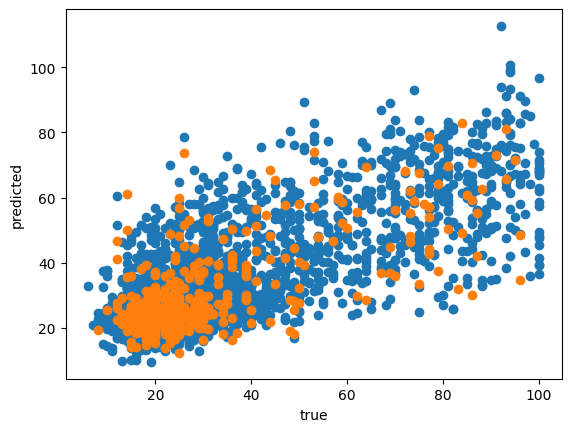

In [15]:

plt.scatter(train_y, y_train_predicted)
plt.scatter(test_y, y_test_predicted)
plt.xlabel('true')
plt.ylabel('predicted')



Cross-validated scores: [-3.24831765e-02 -1.46251709e+00 -1.91142683e+01 -1.50831686e+42]
Cross-Predicted Accuracy: -4.084079499901828e+125


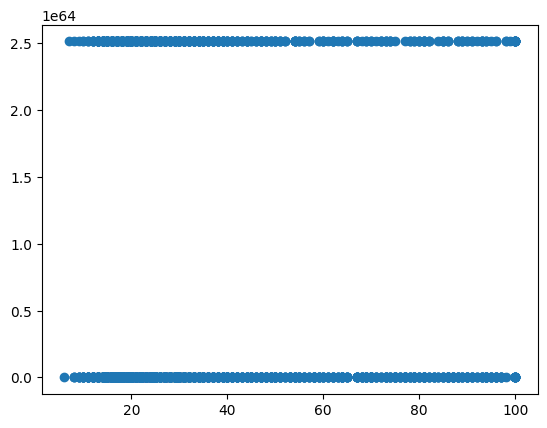

In [16]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

# Perform 4-fold cross validation
scores = cross_val_score(lm, x, y, cv=4)
print("Cross-validated scores:", scores)

# Make cross validated predictions
predictions = cross_val_predict(lm, x, y, cv=4)
plt.scatter(y, predictions)
accuracy = r2_score(y, predictions)

print("Cross-Predicted Accuracy:", accuracy)

Text(0, 0.5, 'predicted')

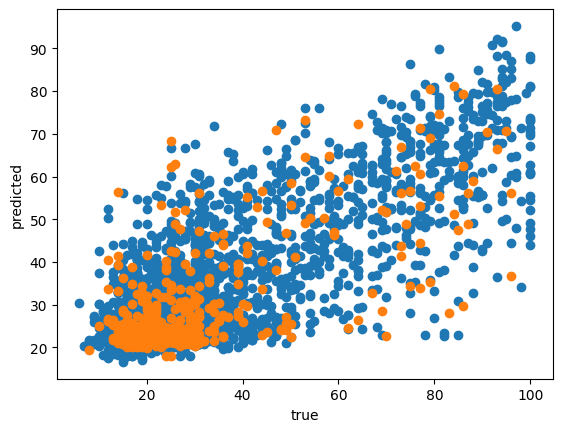

In [17]:
from sklearn.ensemble import GradientBoostingClassifier


lm = get_model('GradientBoostingRegressor')
lm.fit(train_x, train_y)

y_test_predicted = lm.predict(test_x)
y_train_predicted = lm.predict(train_x)



plt.scatter(train_y, y_train_predicted)
plt.scatter(test_y, y_test_predicted)
plt.xlabel('true')
plt.ylabel('predicted')

The model appears to be functioning quite well overall, but there is still space for improvement as seen by the comparatively low R-squared and modified R-squared values as well as the relatively high RMSE number. The performance of the model might benefit from deep learning investigation and optimization.

Cross-validated scores: [-0.02879107 -0.03356171 -0.02574247 -0.01567901]
Cross-Predicted Accuracy: -0.025870878962246824


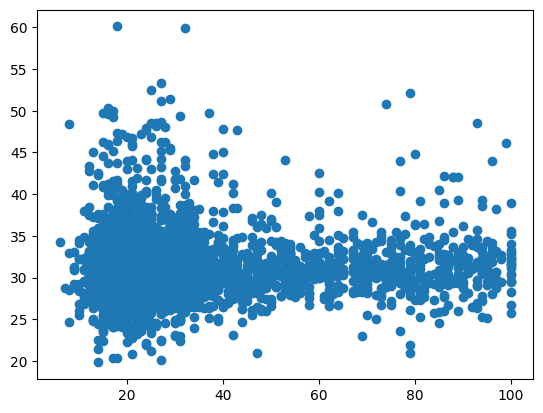

In [18]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

# Perform 4-fold cross validation
scores = cross_val_score(lm, x, y, cv=4)
print("Cross-validated scores:", scores)

# Make cross validated predictions
predictions = cross_val_predict(lm, x, y, cv=4)
plt.scatter(y, predictions)
accuracy = r2_score(y, predictions)

print("Cross-Predicted Accuracy:", accuracy)

## Deep Learning 

In [19]:
from matplotlib import pyplot as plt
def show_results(history, hidden_layers, hidden_layer_units):

    #plot the training and validation accuracy and loss at each epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{hidden_layers}_hidden_layers_{hidden_layer_units}_units Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    acc = history.history['mae']
    val_acc = history.history['val_mae']
    plt.plot(epochs, acc, 'y', label='Training MAE')
    plt.plot(epochs, val_acc, 'r', label='Validation MAE')
    plt.title(f'{hidden_layers}_hidden_layers_{hidden_layer_units}_units Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.models import load_model


def nnetwork(hidden_layers, hidden_layer_units):
    NN_model = Sequential()

    # The Input Layer :
    NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X.shape[1], activation='relu'))

    # The Hidden Layers :
    for i in range(hidden_layers):
        NN_model.add(Dense(hidden_layer_units, kernel_initializer='normal',activation='relu'))

    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

    # Compile the network :
    NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

    # saving and loading the .h5 model
 
    # save model
    h5_path = f"D:/TELLUS/Calcimetrie/ai.calcimetry/pkl_models/NN_{hidden_layers}_hidden_layers_{hidden_layer_units}_units.h5"
    NN_model.save(h5_path)
    print('Model Saved!')
    
    # load model
    savedModel=load_model(h5_path)
    savedModel.summary()
    return NN_model

In [22]:
# model = nnetwork(5, 512)
# history = model.fit(X_train, y_train, epochs =100, validation_data=(X_test, y_test))
# show_results(history, 5, 512)


In [ ]:
# model = nnetwork(20, 256)
# history = model.fit(X_train, y_train, epochs =100, validation_data=(X_test, y_test))
# show_results(history, 20, 256)


In [ ]:
# model = nnetwork(40, 128)
# history = model.fit(X_train, y_train, epochs =100, validation_data=(X_test, y_test))
# show_results(history, 40, 128)


## Models saving

In [23]:
import pickle


def testing_and_saving_model(model_name, train_x=train_x, train_y=train_y, test_x=test_x):
        
    lm = get_model(model_name)
    lm.fit(train_x, train_y)

    y_test_predicted = lm.predict(test_x)
    # y_train_predicted = lm.predict(train_x)
    #Save the file
    pkl_name = f"D:/TELLUS/Calcimetrie/ai.calcimetry/pkl_models/{model_name}.pkl"
    with open(pkl_name, "wb") as file:
        pickle.dump(lm, file)

    #Load from file
    with open(pkl_name, 'rb') as file :
        pickle_model = pickle.load(file)


    #Calculate the scores values
    score = r2_score(test_y, y_test_predicted)
    print(f'{model_name}Test score: {0:.2f} %'.format(100*score))

In [24]:
testing_and_saving_model('RandomForest')

RandomForestTest score: 0.00 %


In [25]:
testing_and_saving_model('mlp')

mlpTest score: 0.00 %


In [26]:
testing_and_saving_model('GradientBoostingRegressor')

GradientBoostingRegressorTest score: 0.00 %


# Conclusion

The Gradient Boosting Regressor seeks to forecast a continuous target variable from a set of input characteristics. Several weak models, like decision trees, are combined into a strong ensemble model via the procedure.

According to the data you provided, cross-validation was used to test the Gradient Boosting Regressor. Cross-validation is a method for evaluating the performance of a model by dividing the data into numerous folds and training and evaluating the model on various subsets of the data.

The mean squared error (MSE) of the model on each cross-validation fold is represented by the cross-validation scores [0.03146509, 0.03441495, 0.04031465, 0.03444882]. The average squared difference between the anticipated and actual values is measured by the MSE evaluation metric, which is frequently used for regression issues. In this situation, the model obtained relatively low MSE scores, which shows that it is doing well on the data. Lower values of MSE indicate higher performance.

Another evaluation metric for regression issues is the R squared score, which represents the percentage of variance in the target variable that is explained by the model and has a value of -1.0810060255831067. R squared is a performance metric with a range of 0 to 1, with larger values signifying better results. A model that performs worse than one that merely predicts the mean value of the target variable has a negative R squared value. In this instance, the model is most certainly overfitting the data as indicated by the negative R squared. A model learns to fit the noise in the data rather than the underlying pattern when it overfits, which leads to poor generalization to fresh data.

### Single image inference

In [28]:
# from calcimetry.mongo_api import MongoInfo
# from calcimetry.thumbnail_api import ThumbnailAPI
# from PIL import Image
# import matplotlib.pyplot as plt
# import io
# import random
# import base64
# from IPython.display import HTML
# import pandas as pd
# import numpy as np
# from calcimetry.thumbnail_api import ThumbnailAPI
# from sklearn.linear_model import MLPRegressor
# from sklearn.utils import shuffle

# # Initialize the regression model
# def get_model(kind):
#     return { 
#         'ridge': BayesianRidge(), 
#         'linear': LinearRegression(), 
#         "ard": ARDRegression(),
#         "RandomForest": RandomForestRegressor(n_estimators=100),
#         "mlp": MLPRegressor(max_iter=1000, solver='sgd', learning_rate="adaptive"),
#         "GradientBoostingRegressor": GradientBoostingRegressor(n_estimators=100, random_state=123)
#     }[kind]

# # Load Dataset
# HOST = 'localhost'
# PORT = 27010

# random.seed(1)

# mongo_info = MongoInfo(host=HOST, port=PORT)
# thumb_list = []
# with ThumbnailAPI(mongo_info=mongo_info) as thumb_api:
#     size = thumb_api.size()
#     print(size)
#     for i in range(10):
#         idx = int(random.random() * size)
#         thumb = thumb_api.read(idx)
#         thumb_list.append(thumb)

# print('Loaded images')

# # Function to extract histogram features from an image
# def get_histo(img, n_bins):
#     gray = img.convert('L')
#     fig, ax = plt.subplots(nrows=1, ncols=1)
#     ax.set_axis_off()
#     ax.plot(gray.histogram())
#     img_byte_array = io.BytesIO()
#     fig.savefig(img_byte_array, format='jpeg')
#     plt.close(fig)
#     return base64.b64encode(img_byte_array.getvalue()).decode()

# # Function to save histogram features to a file
# def save_histo(img, filename):
#     gray = img.convert('L')
#     fig, ax = plt.subplots(nrows=1, ncols=1)
#     ax.set_axis_off()
#     ax.plot(gray.histogram())
#     fig.savefig(filename, format='jpeg')
#     plt.close(fig)

# # Function to convert an image to base64
# def to_base64(img: Image):
#     byte_array = io.BytesIO()
#     img.save(byte_array, format='jpeg')
#     return base64.b64encode(byte_array.getvalue()).decode()

# # HTML template for displaying images and their features
# html_str = "<div style='display: inline-block; align:justify; border: 1px solid white;'>"
# html_str += "<img style='width: 128px; margin: 0px; float: left; 'src='./regression_files/images_%d.jpg' />"
# html_str += "<img style='width: 128px; margin: 0px; float: left; ' src='./regression_files/histo_%d.jpg' />"
# html_str += "<P style='text-align: center;'>%s (%s)</P>"
# html_str += "</div>\n"

# all_str = " "
# for i, t in enumerate(thumb_list):
#     t.jpg.save(f"./regression_files/images_{i}.jpg", format="jpeg")
#     save_histo(t.jpg, f"./regression_files/histo_{i}.jpg")
#     all_str += html_str % (i, i, t.measurement.val_1m, t.measurement.image_id)

# # Display images and their features
# HTML(all_str)

# # Number of histogram bins
# n_bins = 6

# # Function to extract histogram features from an image
# def get_histo(t, n_bins):
#     w, h = t.jpg.size
#     histo, bins = np.histogram(t.jpg, bins=n_bins)
#     return histo.astype(np.float64) / (w * h)

# # Create a DataFrame for learning
# columns = [
#     "focus", "mean_grad", "mean_color", "brisque"
# ]
# for i in range(n_bins):
#     columns.append(f"bin_{i}")
# columns.append('target')

# data = []

# with ThumbnailAPI(mongo_info=mongo_info) as thumb_api:
#     size = thumb_api.size()
#     for idx in range(size):
#         t = thumb_api.read(idx)
#         row = [t.quality.focus, t.quality.gradient['ave'], np.mean(t.quality.colours), t.quality.brisque]
#         histo = get_histo(t, n_bins)
#         for i in range(n_bins):
#             row.append(histo[i])
#         row.append(float(t.measurement.val_1m))
#         data.append(row)

# # Create the DataFrame
# df = pd.DataFrame(data, columns=columns)
# print(f"There are {df.count()} samples")
# df.head()

# # Normalize the DataFrame
# normalized_df = df.copy()
# for c in columns:
#     if c == 'target':
#         continue
#     mean = normalized_df[c].mean()
#     std = normalized_df[c].std()
#     normalized_df[c] = (df[c] - mean) / std

# normalized_df.head()

# # Independent variables / explanatory variables / features
# x = normalized_df.drop(labels='target', axis=1)

# # Dependent variable / response / target variable / calcimetry
# y = normalized_df['target']

# # from sklearn.model_selection import train_test_split

# # Split the dataset into 90%-10% train-test split
# train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.10, random_state=123, shuffle=True)

# # Shuffle the data for training
# X, y = shuffle(train_x, train_y, random_state=123)
# X = X.astype(np.float32)

# offset = int(X.shape[0] * 0.9)

# # Split the shuffled data into training and validation sets
# X_train, y_train = X[:offset], y[:offset]
# X_test, y_test = X[offset:], y[offset:]

# # Initialize the MLP regression model
# lm = get_model('mlp')
# lm.fit(X_train, y_train)

# # Load and process the new image you want to predict
# new_image = Image.open('path_to_your_new_image.jpg')  # Replace with the path to your new image
# new_image = new_image.convert('L')  # Convert to grayscale if needed

# # Extract histogram features from the new image
# new_image_features = get_histo(new_image, n_bins)

# # Normalize the features of the new image (using the same mean and std as in training)
# mean = normalized_df.drop(labels='target', axis=1).mean()
# std = normalized_df.drop(labels='target', axis=1).std()
# new_image_features = (new_image_features - mean) / std

# # Use the trained regression model to predict the target value for the new image
# predicted_value = lm.predict([new_image_features])

# print("Predicted Value:", predicted_value)


## Image Inference

In [75]:
# from bson import ObjectId
import numpy as np
import pandas as pd
from calcimetry.mongo_api import MongoInfo
from calcimetry.thumbnail_api import ThumbnailAPI
from PIL import Image
import matplotlib.pyplot as plt
import io
import random
import base64
import os
from calcimetry.mongo_api import MongoInfo
from calcimetry.calcimetry_api import CalcimetryAPI
from PIL import Image
from calcimetry.thumbnail_api import ThumbnailAPI
# Create an instance of CalcimetryAPI with your MongoDB information
# mongo_info = MongoInfo("your-mongodb-uri", "your-database-name")
HOST = 'localhost'
PORT = 27010

# Load Dataset

random.seed(1)

mongo_info = MongoInfo(host=HOST, port=PORT)


n_bins = 6

class Config:
    HOST="localhost" #"irlinv-tellus"
    PORT=27010 #27017
    ROOT_URL= '/calcimetry/'

    @staticmethod
    def mongo_info():
        
        if 'MONGODB' in os.environ:
            params = os.environ['MONGODB'].split(':')
            host=params[0]
            port=int(params[1])
        else:
            host = Config.HOST
            port = Config.PORT

        #print(host, port)
        return MongoInfo(host=host, port=port)
    

def get_histo(t, n_bins):
    w, h = t.jpg.size
    histo, bins = np.histogram(t.jpg, bins=n_bins)
    return histo.astype(np.float64) / (w*h)

#create dataframe for learing
columns = [
    "focus", "mean_grad", "mean_color", "brisque"
]
for i in range(n_bins):
    columns.append(f"bin_{i}")
columns.append('target')
    
data = []


with ThumbnailAPI(mongo_info=Config.mongo_info()) as thumb_api , CalcimetryAPI(mongo_info=Config.mongo_info()) as calci_api:
    size = thumb_api.size()    
    idx = 0
    # for idx in range(size):
    t , image_mongo_id, filename = thumb_api.mongo_image_id(idx, Config.mongo_info())
    print(f"filename =>{filename}")
    row = [t.quality.focus, t.quality.gradient['ave'], np.mean(t.quality.colours), t.quality.brisque]
    histo = get_histo(t, n_bins)
    for i in range(n_bins):
        row.append(histo[i])
    row.append(float(t.measurement.val_1m))
    data.append(row)
    
df_inference = pd.DataFrame(data, columns=columns)
print(f"there are {df_inference.count()} samples")
df_inference.head()

filename =>GTR2012-07_0023_BPE4023_0000_0110.jpg
there are focus         1
mean_grad     1
mean_color    1
brisque       1
bin_0         1
bin_1         1
bin_2         1
bin_3         1
bin_4         1
bin_5         1
target        1
dtype: int64 samples


,focus,mean_grad,mean_color,brisque,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,target
0,168.300274,42.614488,93.551401,25.967468,0.00885,0.133545,0.891785,1.164612,0.733643,0.067566,29.0


In [76]:
from sklearn.ensemble import GradientBoostingClassifier


lm = get_model('GradientBoostingRegressor')
lm.fit(train_x, train_y)

test_x = df_inference.drop(labels='target', axis=1)
# y_test_predicted = lm.predict(np.array(test_x).reshape(1, -1))
y_test_predicted = lm.predict(test_x)
# y_train_predicted = lm.predict(train_x)



# plt.scatter(train_y, y_train_predicted)
# plt.scatter(test_y, y_test_predicted)
# plt.xlabel('true')
# plt.ylabel('predicted')

filename =>GTR2012-07_0023_BPE4023_0000_0110.jpg


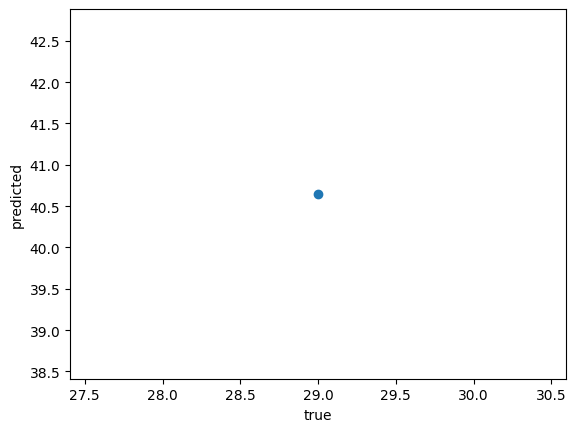

In [85]:

plt.scatter(df_inference['target'], y_test_predicted)
plt.xlabel('true')
plt.ylabel('predicted')
print(f"filename =>{filename}")

In [86]:
all_str = " "

html_str = "<div style='display: inline-block; align:justify; border: 1px solid white;'>"
html_str +="<img style='width: 128px; margin: 0px; float: left; 'src='./regression_files/images_%d.jpg' />"
html_str += "<img style='width: 128px; margin: 0px; float: left; ' src='./regression_files/histo_%d.jpg' />"
html_str +="<P style='text-align: center;'>%s (%s)</P>"
html_str +="</div>\n"
# for i, t in enumerate(thumb_list):
#     t.jpg.save(f"./regression_files/images_{i}.jpg", format="jpeg")
#     save_histo(t.jpg, f"./regression_files/histo_{i}.jpg")
all_str += html_str % (idx, idx, t.measurement.val_1m, t.measurement.image_id)
print(f"filename =>{filename}")
HTML(all_str)

filename =>GTR2012-07_0023_BPE4023_0000_0110.jpg
